In [97]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Load your datasets
df_train = pd.read_csv('/content/training_data_percentage.csv')
df_test = pd.read_csv('/content/control_data_percentage.csv')

def preprocess_data(df):
    datetime_cols = ['user_created_at', 'kyc_created_at', 'deposit_created_at']
    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col])
        df[col+'_year'] = df[col].dt.year
        df[col+'_month'] = df[col].dt.month
        df[col+'_day'] = df[col].dt.day
        df[col+'_hour'] = df[col].dt.hour
        df[col+'_minute'] = df[col].dt.minute
        df[col+'_second'] = df[col].dt.second
        df = df.drop(col, axis=1)

    df['deposit_ip'] = df['deposit_ip'].apply(lambda x: x.split(':')[1].split(',')[0].replace('"', ''))
    df['deposit_language'] = df['deposit_language'].apply(lambda x: x.split(',')[0])

    df['deposit_amount'] = pd.to_numeric(df['deposit_amount'], errors='coerce')
    df['deposit_amount'].fillna(df['deposit_amount'].median(), inplace=True)
    df.fillna('Unknown', inplace=True)

    return df


df_train = preprocess_data(df_train)
df_test = preprocess_data(df_test)

df_train = df_train.drop(['deposit_card_country','deposit_fraud', 'deposit_disputed'], axis = 1)
df_test= df_test.drop(['deposit_card_country','deposit_fraud', 'deposit_disputed'], axis = 1)

target = 'fraudulent'

X_train = df_train.drop([target, 'user_id', 'deposit_id'], axis=1)
y_train = df_train[target]
X_test = df_test.drop([target, 'user_id', 'deposit_id'], axis=1)


encoder = LabelEncoder()

categorical_cols = ['user_country_code', 'kyc_citizenship', 'kyc_permanentcountry',
                    'deposit_currency', 'deposit_email',
                    'deposit_device', 'deposit_language', 'deposit_status',
                    'deposit_failure_message', 'deposit_ip']

for col in categorical_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)
    encoder.fit(pd.concat([X_train[col], X_test[col]]))
    X_train[col] = encoder.transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])

numerical_cols = ['user_created_at_year', 'user_created_at_month', 'user_created_at_day',
                  'user_created_at_hour', 'user_created_at_minute', 'user_created_at_second',
                  'kyc_created_at_year', 'kyc_created_at_month', 'kyc_created_at_day',
                  'kyc_created_at_hour', 'kyc_created_at_minute', 'kyc_created_at_second',
                  'deposit_created_at_year', 'deposit_created_at_month', 'deposit_created_at_day',
                  'deposit_created_at_hour', 'deposit_created_at_minute', 'deposit_created_at_second',
                  'deposit_amount']

for col in numerical_cols:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_train[col].fillna(X_train[col].median(), inplace=True)

    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
    X_test[col].fillna(X_test[col].median(), inplace=True)

# Since 'fraudulent' is a binary variable, it can be directly converted to integers
y_train = y_train.replace({'True': 1, 'False': 0}).astype(int)

classifier = RandomForestClassifier(n_estimators = 100, random_state = 0)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)



In [98]:
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [99]:
y_pred = y_pred.astype(bool)

# Create a DataFrame containing the user_id and predicted 'fraudulent' values
result_df = pd.DataFrame({'user_id': df_test['user_id'], 'fraudulent': y_pred})

# Save the DataFrame to a CSV file
result_df.to_csv('predicted_fraudulent.csv', index=False)

In [100]:
from joblib import dump, load

# Save the model to a file
dump(classifier, 'fraud.joblib')

# Save the LabelEncoder
dump(le, 'label_encoder.joblib')

['label_encoder.joblib']

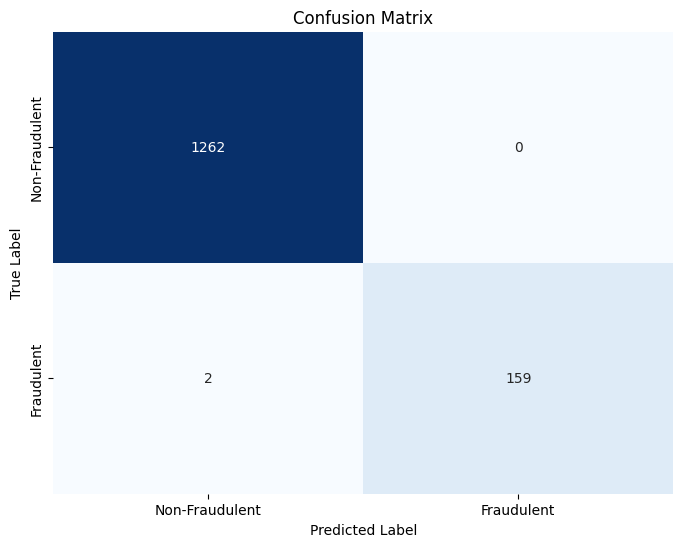

In [105]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Step 1: Load data from CSV files
df1 = pd.read_csv('/content/output.csv')
df2 = pd.read_csv('/content/predicted_fraudulent.csv')

y_true = df1['fraudulent'].values
y_pred = df2['fraudulent'].values

# Step 4: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 5: Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraudulent', 'Fraudulent'],
            yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()